C:\Users\cvais\AppData\Local\Temp\ipykernel_9648\2687508948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


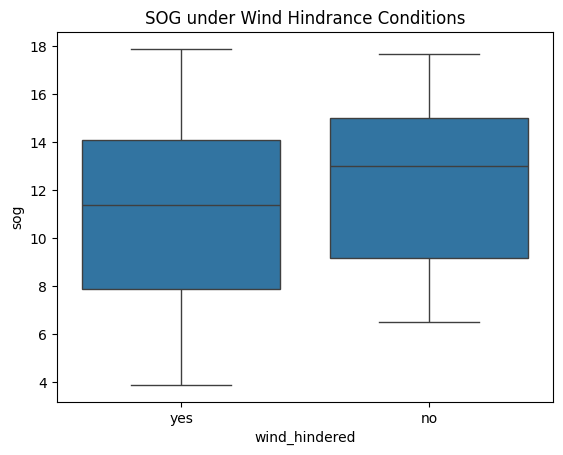

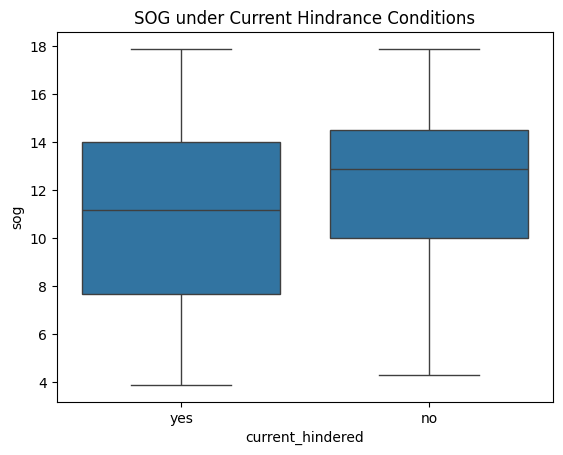

In [7]:
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# DB config
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "AMS_ship_traj03",
    "database": "ship_data",
}

# Helper to query MySQL
def load_query(query):
    cnx = mysql.connector.connect(**db_config)
    df = pd.read_sql(query, cnx)
    cnx.close()
    return df

query = """
SELECT sog, wind_hindered, current_hindered
FROM ais_open_water_polygon_env
WHERE sog IS NOT NULL AND wind_hindered IS NOT NULL AND current_hindered IS NOT NULL and ship_type between 60 and 80
and navigational_status = 0
"""
df = load_query(query)

sns.boxplot(data=df, x="wind_hindered", y="sog")
plt.title("SOG under Wind Hindrance Conditions")
plt.show()

sns.boxplot(data=df, x="current_hindered", y="sog")
plt.title("SOG under Current Hindrance Conditions")
plt.show()



Speed Drop (ΔSOG) Relative to Unhindered

In [6]:
grouped = df.groupby(["wind_hindered", "current_hindered"])["sog"].agg(["mean", "count"]).reset_index()
unhindered_mean = grouped.query("wind_hindered == 'no' and current_hindered == 'no'")["mean"].values[0]
grouped["delta_sog"] = grouped["mean"] - unhindered_mean
grouped


,wind_hindered,current_hindered,mean,count,delta_sog
0,no,no,12.531507,438,0.000000
1,no,yes,12.431087,846,-0.100419
2,yes,no,11.188480,1927,-1.343027
3,yes,yes,9.641683,5134,-2.889824


SOG by Wind Hindrance and Direction

C:\Users\cvais\AppData\Local\Temp\ipykernel_13764\591264686.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


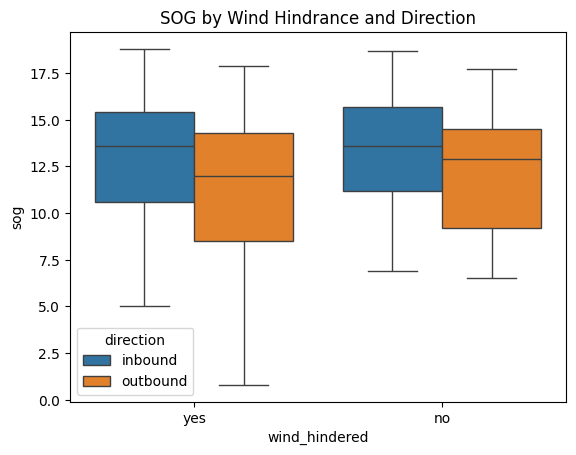

In [30]:
query = """
SELECT sog, cog, wind_hindered, current_hindered
FROM ais_open_water_polygon_env
WHERE sog IS NOT NULL AND cog IS NOT NULL and ship_type between 60 and 80
and navigational_status = 0;
"""
df = load_query(query)
df["direction"] = df["cog"].apply(lambda x: "inbound" if 180 <= x <= 360 else "outbound")

sns.boxplot(data=df, x="wind_hindered", y="sog", hue="direction")
plt.title("SOG by Wind Hindrance and Direction")
plt.show()


Wind allignment check

In [31]:
query = """
SELECT sog, cog, wind_direction_10m, wind_hindered, current_hindered
FROM ais_open_water_polygon_env
WHERE sog IS NOT NULL 
  AND cog IS NOT NULL 
  AND wind_direction_10m IS NOT NULL
  AND ship_type BETWEEN 60 AND 80
  AND navigational_status = 0;
"""
df = load_query(query)

df.columns = df.columns.str.lower()
df["direction"] = df["cog"].apply(lambda x: "inbound" if 180 <= x <= 360 else "outbound")
print(df.columns)



C:\Users\cvais\AppData\Local\Temp\ipykernel_13764\591264686.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


Index(['sog', 'cog', 'wind_direction_10m', 'wind_hindered', 'current_hindered',
       'direction'],
      dtype='object')


In [18]:
def classify_wind_alignment(cog, wind_dir):
    angle = (wind_dir - cog + 360) % 360
    if angle <= 45 or angle >= 315:
        return "tailwind"
    elif 135 <= angle <= 225:
        return "headwind"
    else:
        return "crosswind"

df["wind_alignment"] = df.apply(lambda r: classify_wind_alignment(r["cog"], r["wind_direction_10m"]), axis=1)


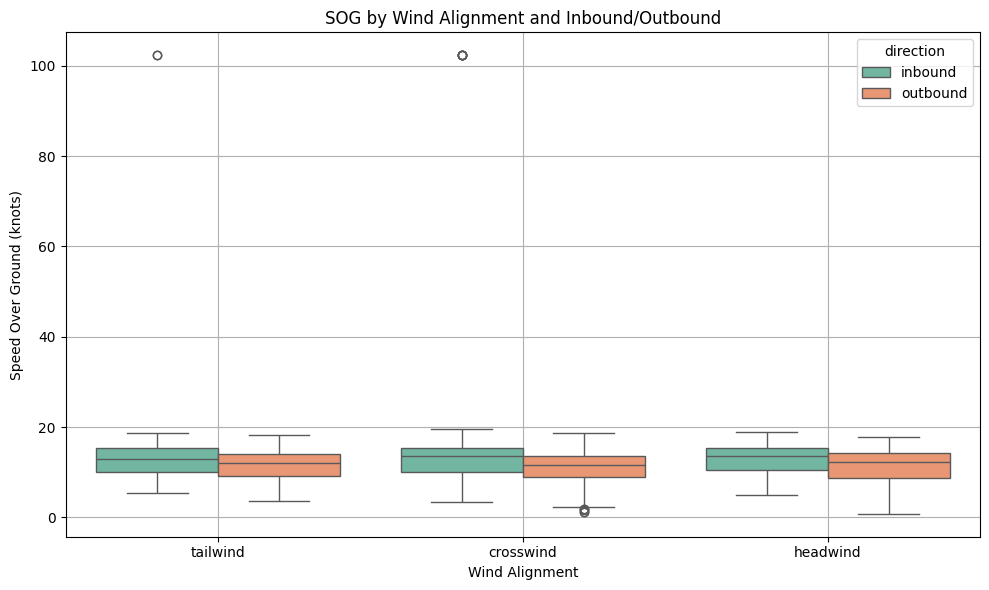

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="wind_alignment", y="sog", hue="direction", palette="Set2")
plt.title("SOG by Wind Alignment and Inbound/Outbound")
plt.ylabel("Speed Over Ground (knots)")
plt.xlabel("Wind Alignment")
plt.grid(True)
plt.tight_layout()
plt.show()


SOG over Time under Wind Hindrance

C:\Users\cvais\AppData\Local\Temp\ipykernel_7488\2745989418.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)
C:\Users\cvais\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


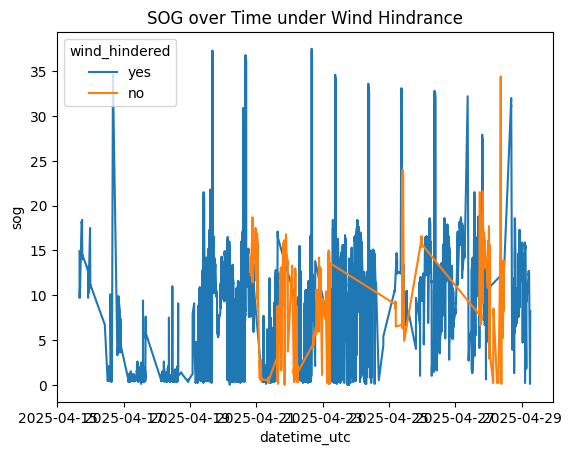

In [ ]:
# SOG over time
query = """
SELECT datetime_utc, sog, wind_hindered
FROM ais_open_water_polygon_env
WHERE datetime_utc IS NOT NULL AND wind_hindered IS NOT NULL and ship_type =70
"""
df = load_query(query)

df["datetime_utc"] = pd.to_datetime(df["datetime_utc"])
sns.lineplot(data=df, x="datetime_utc", y="sog", hue="wind_hindered")
plt.title("SOG over Time under Wind Hindrance")
plt.show()



C:\Users\cvais\AppData\Local\Temp\ipykernel_9648\2687508948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


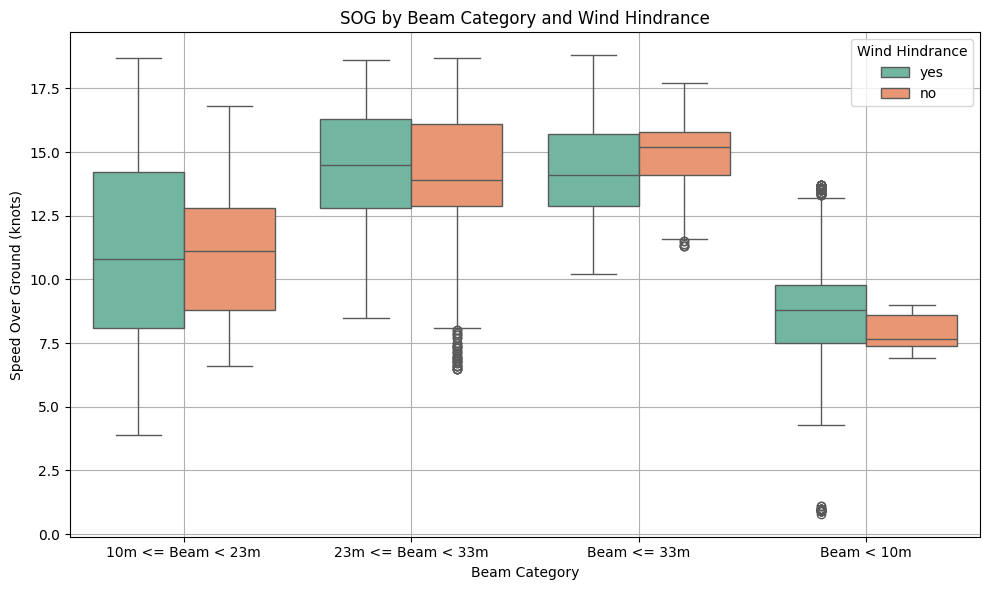

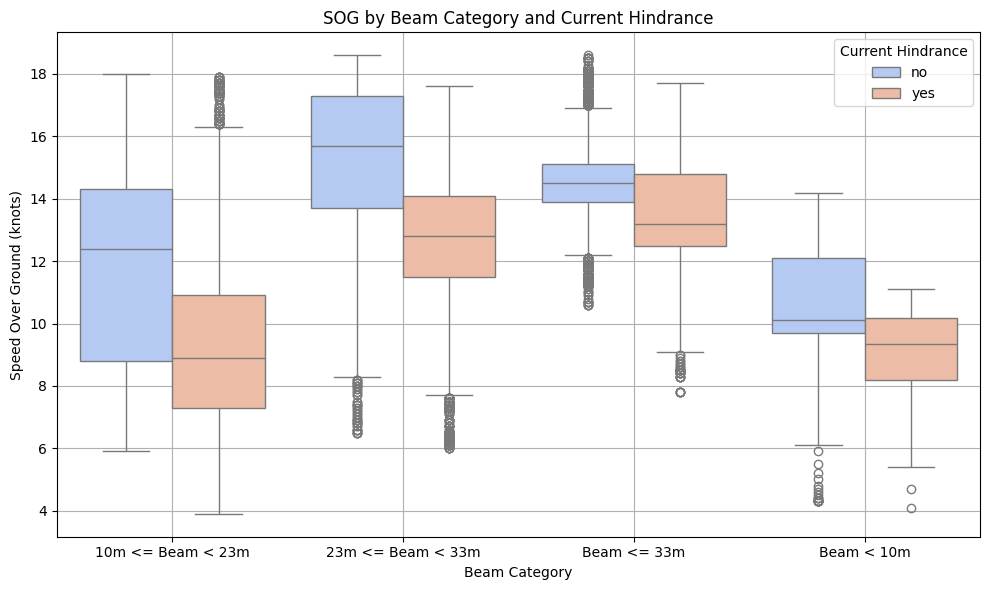


 Median SOG by Beam Category and Wind Hindrance:
wind_hindered         no   yes
beam_category                 
10m <= Beam < 23m  11.10  10.8
23m <= Beam < 33m  13.90  14.5
Beam < 10m          7.65   8.8
Beam <= 33m        15.20  14.1

 Mean SOG by Beam Category and Wind Hindrance:
       beam_category wind_hindered       mean  count
0  10m <= Beam < 23m            no  11.051498   3538
1  10m <= Beam < 23m           yes  10.977198  22853
2  23m <= Beam < 33m            no  13.857627   1711
3  23m <= Beam < 33m           yes  14.489125  10290
4         Beam < 10m            no   7.877551     98
5         Beam < 10m           yes   8.789200   1037
6        Beam <= 33m            no  14.860870   1932
7        Beam <= 33m           yes  14.248416   6692

 Mean SOG by Beam Category and Current Hindrance:
       beam_category current_hindered       mean  count
0  10m <= Beam < 23m               no  11.766803  10754
1  10m <= Beam < 23m              yes   9.187097  24281
2  23m <= Beam < 33m

Text(0.5, 1.05, 'Median SOG by Beam, Direction, and Wind Hindrance')

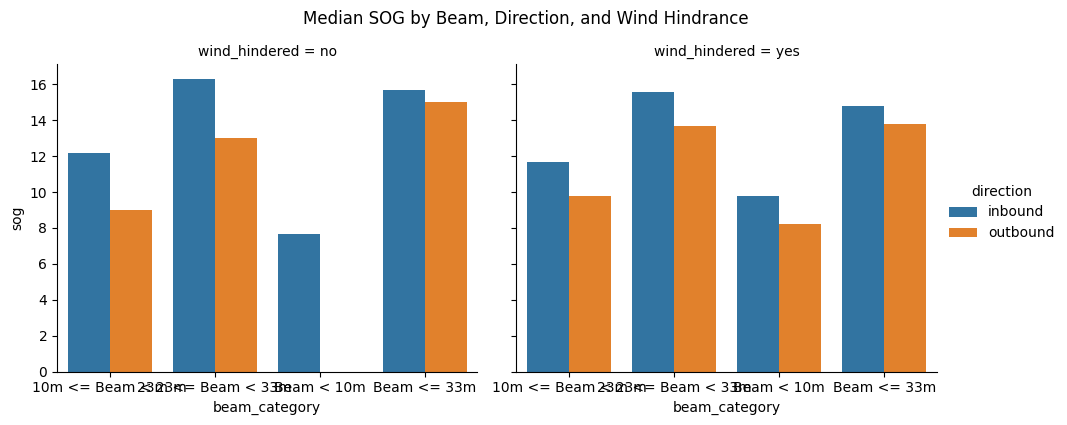

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT sog,cog, wind_hindered, current_hindered, beam_category
FROM ais_open_water_polygon_env
WHERE sog IS NOT NULL AND beam_category IS NOT NULL and ship_type between 60 and 80
and navigational_status = 0
"""
df = load_query(query)


# 1.  Boxplot of SOG vs. Beam Category under Wind Hindrance
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="beam_category", y="sog", hue="wind_hindered", palette="Set2")
plt.title("SOG by Beam Category and Wind Hindrance")
plt.ylabel("Speed Over Ground (knots)")
plt.xlabel("Beam Category")
plt.grid(True)
plt.legend(title="Wind Hindrance")
plt.tight_layout()
plt.show()

# 2.  Boxplot of SOG vs. Beam Category under Current Hindrance
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="beam_category", y="sog", hue="current_hindered", palette="coolwarm")
plt.title("SOG by Beam Category and Current Hindrance")
plt.ylabel("Speed Over Ground (knots)")
plt.xlabel("Beam Category")
plt.grid(True)
plt.legend(title="Current Hindrance")
plt.tight_layout()
plt.show()

# 3.  Print mean SOG values by beam category and wind/current hindrance
print("\n Median SOG by Beam Category and Wind Hindrance:")
df["direction"] = df["cog"].apply(lambda x: "inbound" if 180 <= x <= 360 else "outbound")
print (df.groupby(["beam_category", "wind_hindered"])["sog"].median().unstack())

print("\n Mean SOG by Beam Category and Wind Hindrance:")
print(df.groupby(["beam_category", "wind_hindered"])["sog"].agg(['mean', 'count']).reset_index())

print("\n Mean SOG by Beam Category and Current Hindrance:")
print(df.groupby(["beam_category", "current_hindered"])["sog"].agg(['mean', 'count']).reset_index())


df["direction"] = df["cog"].apply(lambda x: "inbound" if 180 <= x <= 360 else "outbound")
df.groupby(["beam_category", "wind_hindered", "direction"])["sog"].mean().unstack()


pivot = df.groupby(["beam_category", "current_hindered"])["sog"].mean().unstack()
pivot["sog_drop"] = pivot["no"] - pivot["yes"]
print(pivot)

df_plot = df.groupby(["beam_category", "wind_hindered", "direction"])["sog"].median().reset_index()
sns.catplot(data=df_plot, x="beam_category", y="sog", hue="direction", col="wind_hindered", kind="bar", height=4, aspect=1.2)
plt.suptitle("Median SOG by Beam, Direction, and Wind Hindrance", y=1.05)


wind direction check

In [30]:
import numpy as np
import pandas as pd


query = """
SELECT sog,cog, wind_hindered, current_hindered, beam_category,wind_direction_10m
FROM ais_open_water_polygon_env
WHERE sog IS NOT NULL AND beam_category IS NOT NULL and ship_type between 60 and 80
and navigational_status = 0
"""
df = load_query(query)

df = df[(df["sog"] >= 3) & (df["sog"] <= 20)]
# Calculate relative wind angle (wind direction relative to vessel course)
df['rel_wind_angle'] = (df['wind_direction_10m'] - df['cog']) % 360

# Convert to -180 to 180 range for better interpretation
df['rel_wind_angle_180'] = df['rel_wind_angle'].apply(lambda x: x - 360 if x > 180 else x)

# Categorize relative wind direction
def categorize_wind_angle(angle):
    if -30 <= angle <= 30:
        return 'Headwind'
    elif 60 <= angle <= 120 or -120 <= angle <= -60:
        return 'Beam wind'
    elif angle >= 150 or angle <= -150:
        return 'Following wind'
    else:
        return 'Other'

df['wind_category'] = df['rel_wind_angle_180'].apply(categorize_wind_angle)

# Group by beam category, wind category, and wind hindrance, then calculate mean SOG and counts
result = df.groupby(['beam_category', 'wind_category', 'wind_hindered']).agg(
    mean_sog = ('sog', 'mean'),
    count = ('sog', 'count')
).reset_index()

print(result)


C:\Users\cvais\AppData\Local\Temp\ipykernel_4108\2687508948.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


        beam_category   wind_category wind_hindered   mean_sog  count
0   10m <= Beam < 23m  Following wind           yes  11.173930  17637
1   10m <= Beam < 23m        Headwind            no  10.391998   2012
2   10m <= Beam < 23m           Other            no  11.921035   1526
3   10m <= Beam < 23m           Other           yes  10.311982   5216
4   23m <= Beam < 33m  Following wind           yes  14.487981   7829
5   23m <= Beam < 33m        Headwind            no  13.307777   1363
6   23m <= Beam < 33m           Other            no  16.011207    348
7   23m <= Beam < 33m           Other           yes  14.492767   2461
8          Beam < 10m  Following wind           yes   8.866303    733
9          Beam < 10m        Headwind            no   7.850649     77
10         Beam < 10m           Other            no   7.976190     21
11         Beam < 10m           Other           yes   9.112982    285
12        Beam <= 33m  Following wind           yes  13.957464   4984
13        Beam <= 33

C:\Users\cvais\AppData\Local\Temp\ipykernel_13764\1215550592.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)
C:\Users\cvais\AppData\Local\Temp\ipykernel_13764\1215550592.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="visibility_class", y="sog", palette="coolwarm")


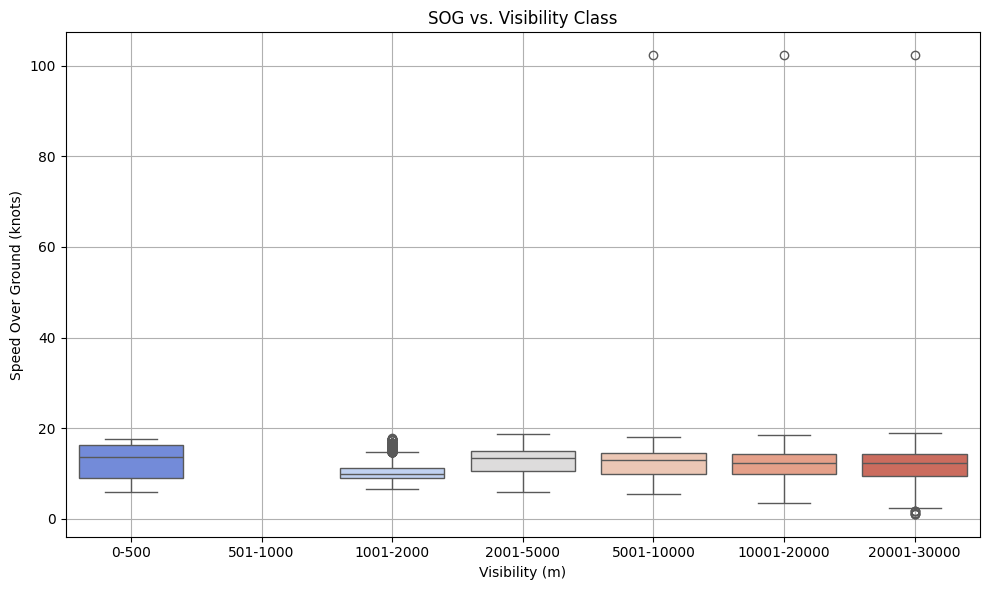


📊 Mean, Median, Count SOG by Visibility Class:
  visibility_class       mean  median  count
0            0-500  12.538657    13.7    551
1        1001-2000  10.890707     9.9   1033
2        2001-5000  12.834113    13.4  15730
3       5001-10000  12.341726    13.0  20311
4      10001-20000  12.172698    12.3  32141
5      20001-30000  12.201114    12.4  35287

🚢 Ship Types in Each Visibility Class:
  visibility_class                            ship_types_present
0            0-500                          [70, 71, 73, 74, 80]
1        1001-2000                      [70, 71, 73, 74, 79, 80]
2        2001-5000              [60, 70, 71, 72, 73, 74, 79, 80]
3       5001-10000  [60, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80]
4      10001-20000      [60, 69, 70, 71, 72, 74, 75, 76, 79, 80]
5      20001-30000  [60, 69, 70, 71, 72, 73, 74, 76, 78, 79, 80]


In [2]:
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- DB config ---
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "AMS_ship_traj03",
    "database": "ship_data",
}

# --- Load relevant columns with filters ---
def load_visibility_data():
    cnx = mysql.connector.connect(**db_config)
    query = """
        SELECT sog, visibility, beam_category, ship_type, navigational_status
        FROM ais_open_water_polygon_env
        WHERE visibility IS NOT NULL AND sog IS NOT NULL
            AND visibility < 30000 AND sog > 1.0
            AND navigational_status = 0
            AND ship_type BETWEEN 60 AND 80
            and ship_type not in (40,51)
    """
    df = pd.read_sql(query, cnx)
    cnx.close()
    return df

df = load_visibility_data()

# --- Bin visibility ---
df["visibility_class"] = pd.cut(
    df["visibility"],
    bins=[0, 500, 1000, 2000, 5000, 10000, 20000, 30000],
    labels=["0-500", "501-1000", "1001-2000", "2001-5000", "5001-10000", "10001-20000", "20001-30000"]
)

# --- Plot SOG by visibility class ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="visibility_class", y="sog", palette="coolwarm")
plt.title("SOG vs. Visibility Class")
plt.xlabel("Visibility (m)")
plt.ylabel("Speed Over Ground (knots)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Grouped stats: mean, median, count ---
group_stats = df.groupby("visibility_class", observed=True)["sog"].agg(['mean', 'median', 'count']).reset_index()
print("\n📊 Mean, Median, Count SOG by Visibility Class:")
print(group_stats)

# --- Ship types per visibility class ---
ship_types_by_bin = df.groupby("visibility_class", observed=True)["ship_type"].apply(lambda x: sorted(x.unique().tolist())).reset_index()
ship_types_by_bin.rename(columns={"ship_type": "ship_types_present"}, inplace=True)
print("\n🚢 Ship Types in Each Visibility Class:")
print(ship_types_by_bin)


In [2]:
import pandas as pd
import mysql.connector

# DB config
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "AMS_ship_traj03",
    "database": "ship_data",
}

# Load encounter table
def load_encounters():
    cnx = mysql.connector.connect(**db_config)
    df = pd.read_sql("SELECT * FROM ais_open_water_polygon_enc", cnx)  # replace with actual name
    cnx.close()
    return df

# Load environment table
def load_environment():
    cnx = mysql.connector.connect(**db_config)
    df = pd.read_sql("SELECT id, sog, wind_hindered, current_hindered, visibility FROM ais_open_water_polygon_env", cnx)
    cnx.close()
    return df

enc_df = load_encounters()
env_df = load_environment()


# Ensure id_1 and id_2 are integers for merging
enc_df["id_1"] = enc_df["id_1"].astype(int)
enc_df["id_2"] = enc_df["id_2"].astype(int)

# Merge environmental data for both ship1 and ship2
enc_df = enc_df.merge(env_df.add_suffix("_1"), left_on="id_1", right_on="id_1", how="left")
enc_df = enc_df.merge(env_df.add_suffix("_2"), left_on="id_2", right_on="id_2", how="left")


# Hindrance if either ship is affected
enc_df["wind_hindered"] = enc_df["wind_hindered_1"].eq("yes") | enc_df["wind_hindered_2"].eq("yes")
enc_df["current_hindered"] = enc_df["current_hindered_1"].eq("yes") | enc_df["current_hindered_2"].eq("yes")
enc_df["low_visibility"] = (enc_df["visibility_1"] < 2000) | (enc_df["visibility_2"] < 2000)

# Average SOG
enc_df["avg_sog"] = (enc_df["sog_1"] + enc_df["sog_2"]) / 2


# Summary by encounter type and hindrance
summary = enc_df.groupby(["encounter_type", "wind_hindered", "current_hindered", "low_visibility"]).agg(
    encounter_count=("id_1", "count"),
    mean_sog=("avg_sog", "mean")
).reset_index()

print(summary)


C:\Users\cvais\AppData\Local\Temp\ipykernel_7500\785942498.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM ais_open_water_polygon_enc", cnx)  # replace with actual name
C:\Users\cvais\AppData\Local\Temp\ipykernel_7500\785942498.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT id, sog, wind_hindered, current_hindered, visibility FROM ais_open_water_polygon_env", cnx)


       encounter_type  wind_hindered  current_hindered  low_visibility  \
0       crossing_port          False             False           False   
1       crossing_port           True             False           False   
2       crossing_port           True              True           False   
3  crossing_starboard          False             False           False   
4             head-on          False             False           False   
5             head-on           True              True           False   
6          overtaking          False             False           False   
7          overtaking           True             False           False   

   encounter_count  mean_sog  
0               15    11.070  
1                6    11.600  
2               10    11.815  
3                7    10.650  
4                2    14.000  
5                5    11.670  
6                6     7.850  
7                1     5.850  


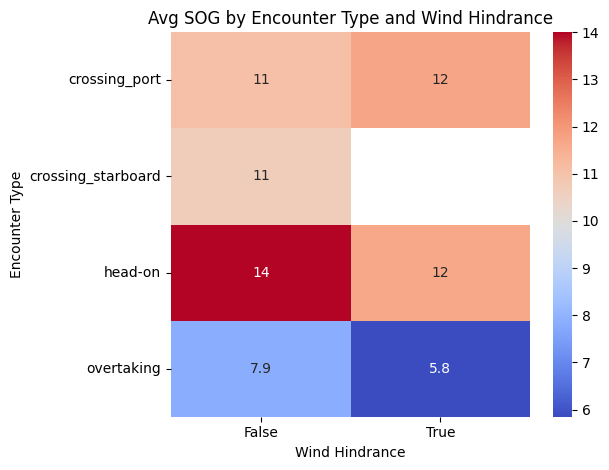

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = enc_df.groupby(["encounter_type", "wind_hindered"])["avg_sog"].mean().unstack()
sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.title("Avg SOG by Encounter Type and Wind Hindrance")
plt.xlabel("Wind Hindrance")
plt.ylabel("Encounter Type")
plt.tight_layout()
plt.show()


C:\Users\cvais\AppData\Local\Temp\ipykernel_9648\1615469845.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnx)


wind_hindered
no     0.103437
yes    0.107889
Name: turn_rate, dtype: float64


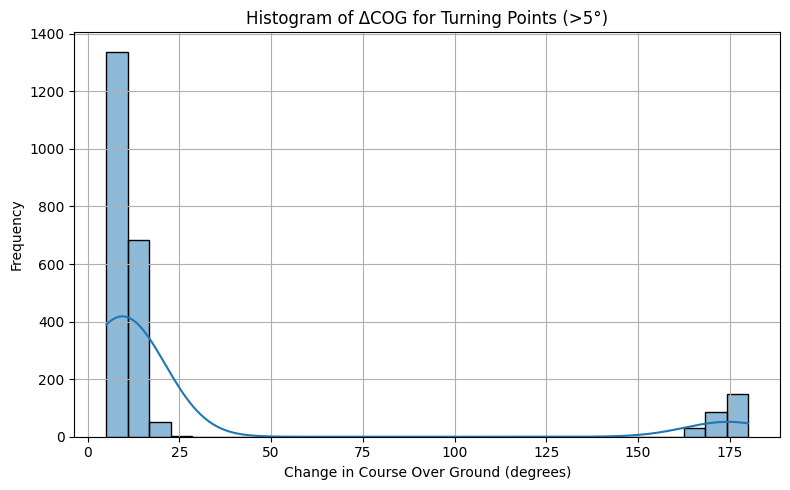

In [16]:
import mysql.connector
import pandas as pd

db_config = {
    "host": "localhost",
    "user": "root",
    "password": "AMS_ship_traj03",
    "database": "ship_data",
}

def load_cog_data():
    cnx = mysql.connector.connect(**db_config)
    query = """
        SELECT mmsi, timestamp_ais, cog, wind_hindered,sog
        FROM ais_open_water_polygon_env
        WHERE cog IS NOT NULL AND wind_hindered IS NOT NULL and ship_type =70 and navigational_status = 0
        ORDER BY mmsi, timestamp_ais
    """
    df = pd.read_sql(query, cnx)
    cnx.close()
    return df

df = load_cog_data()


# Ensure correct type and sorting
df["timestamp_ais"] = pd.to_datetime(df["timestamp_ais"])
df.sort_values(by=["mmsi", "timestamp_ais"], inplace=True)

# Compute ΔCOG
df["delta_cog"] = df.groupby("mmsi")["cog"].diff().abs()

# Normalize wrap-around values (>180° becomes 360 - Δ)
df["delta_cog"] = df["delta_cog"].apply(lambda x: 360 - x if x > 180 else x)

TURN_THRESHOLD = 5  # degrees

df["is_turn"] = df["delta_cog"] > TURN_THRESHOLD

turn_summary = df.groupby(["mmsi", "wind_hindered"]).agg(
    total_points=("delta_cog", "count"),
    turn_count=("is_turn", "sum")
).reset_index()

turn_summary["turn_rate"] = turn_summary["turn_count"] / turn_summary["total_points"]


print(turn_summary.groupby("wind_hindered")["turn_rate"].mean())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df[df["is_turn"]]["delta_cog"], bins=30, kde=True)
plt.title("Histogram of ΔCOG for Turning Points (>5°)")
plt.xlabel("Change in Course Over Ground (degrees)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Turn Angle (ΔCOG) Distribution by Wind Hindrance')

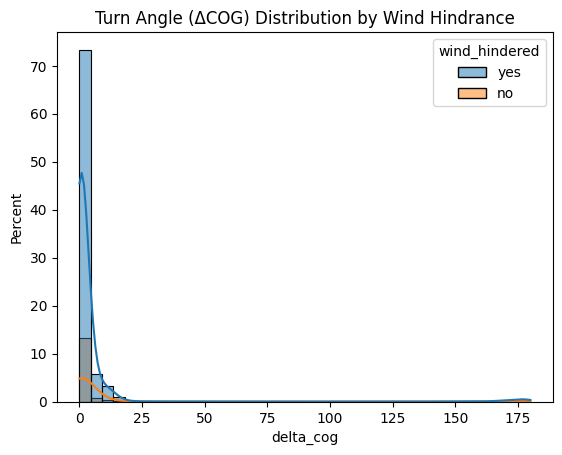

In [13]:
sns.histplot(data=df, x="delta_cog", bins=40, hue="wind_hindered", kde=True, stat="percent")
plt.title("Turn Angle (ΔCOG) Distribution by Wind Hindrance")


Text(0.5, 0, 'Wind Hindrance')

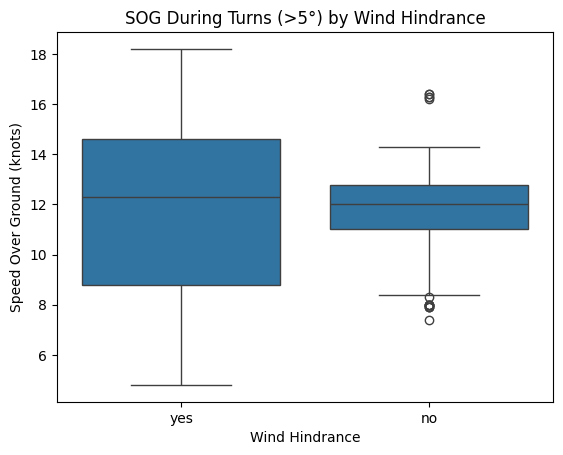

In [19]:
df_turns = df[df["is_turn"]]
sns.boxplot(data=df_turns, x="wind_hindered", y="sog")
plt.title("SOG During Turns (>5°) by Wind Hindrance")
plt.ylabel("Speed Over Ground (knots)")
plt.xlabel("Wind Hindrance")
